In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap
sns.set()
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
data = load_iris()
y = data.target
d = dict(zip(np.hstack((data.feature_names, ['target'])), np.vstack((data.data.T,y))))
df = pd.DataFrame(d)

In [4]:
colors = ListedColormap(['red', 'blue', 'yellow'])
light_colors = ListedColormap(['lightcoral', 'lightblue', 'lightyellow'])

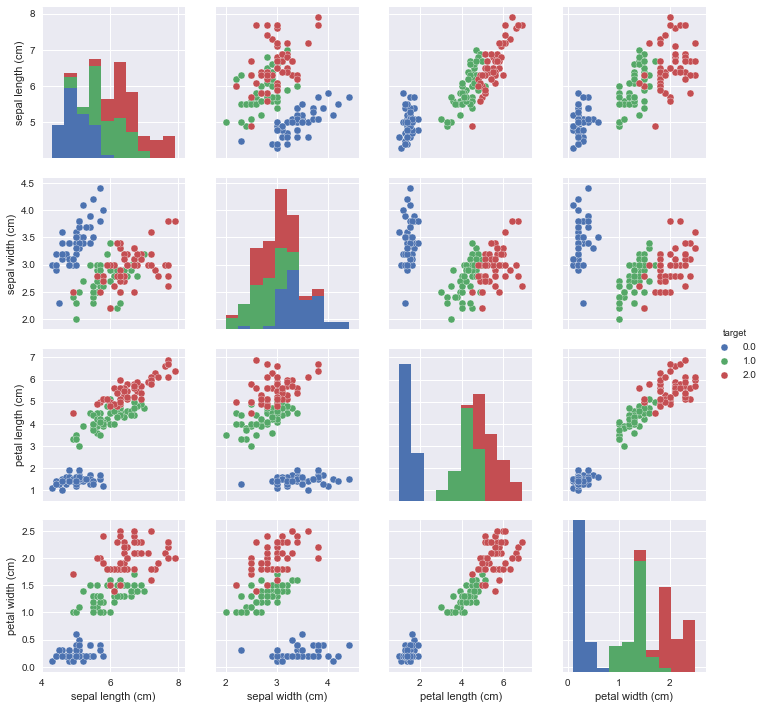

In [5]:
sns.pairplot(df, vars=data.feature_names, hue='target')

Выберем два признака, по которым будем обучать нашу модель. Пусть это будут sepal length (cm) и petal width (cm).

In [6]:
X = df[['sepal length (cm)', 'petal width (cm)']].values

Напишем вспомогательные функции.

In [7]:
# function for plotting error-max_depth_of_DecisionTreeClassifier graphs depending on GridSearchCV results
def plot_scores(optimizer):
    scores = [[item[0]['max_depth'], 
               1-item[1], 
               (np.sum((item[2]-item[1])**2)/(item[2].size-1))**0.5] for item in optimizer.grid_scores_]
    scores = np.array(scores)
    plt.plot(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.xlabel('max_depth', fontsize=14)
    plt.ylabel('error', fontsize=14)
    plt.show()

In [8]:
# return dense coordinate matrices from x, y vectors
def get_meshgrid(data, step=.05, border=.5,):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [9]:
# function for plotting decision surface
def plot_decision_surface(estimator, train_data, train_labels, test_data, test_labels, 
                          colors = colors, light_colors = light_colors):
    #fit model
    estimator.fit(train_data, train_labels)
    
    #set figure size
    pyplot.figure(figsize = (16, 6))
    
    #plot decision surface on the train data 
    pyplot.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(estimator.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    pyplot.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    pyplot.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, s = 100, cmap = colors)
    pyplot.title('Train data, accuracy={:.2f}'.format(accuracy_score(train_labels, estimator.predict(train_data))))
    
    #plot decision surface on the test data
    pyplot.subplot(1,2,2)
    pyplot.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    pyplot.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, s = 100, cmap = colors)
    pyplot.title('Test data, accuracy={:.2f}'.format(accuracy_score(test_labels, estimator.predict(test_data))))
    plt.show()

Найдем оптимальную глубину решающего дерева, которую будем использовать в дальнейшем. Построим графики оценок ошибок +- их стандартного отклонений в зависимости от максимальной глубины дерева.

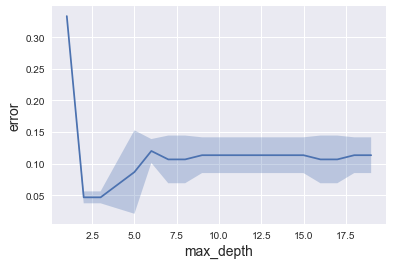

Chosen max_depth for 2 folds is 2


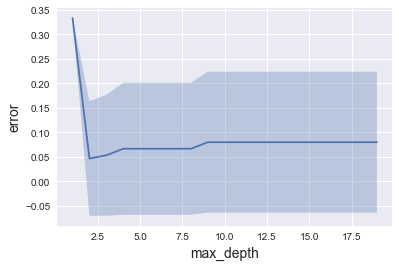

Chosen max_depth for 50 folds is 2


In [10]:
param_grid = {'max_depth' : list(range(1, 20))}

optimizer = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=2)
optimizer.fit(X, y)
plot_scores(optimizer)
print('Chosen max_depth for 2 folds is', optimizer.best_params_['max_depth'])


optimizer = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=50)
optimizer.fit(X, y)
plot_scores(optimizer)
print('Chosen max_depth for 50 folds is', optimizer.best_params_['max_depth'])

Построим графики зависимости значения ошибки и его стандартного отклонения от объема выборки на обучении и контроле.

Test_size = 0.1


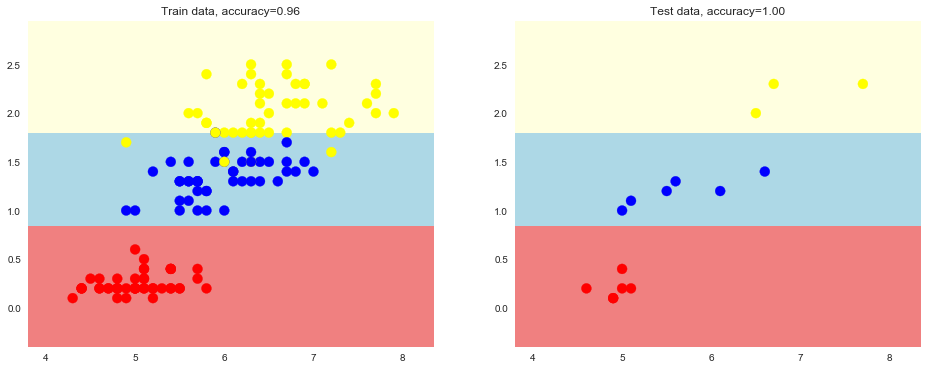

Test_size = 0.2


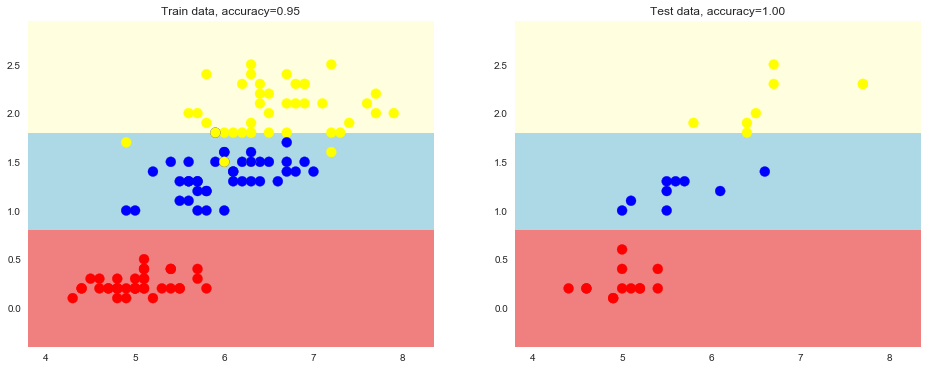

Test_size = 0.3


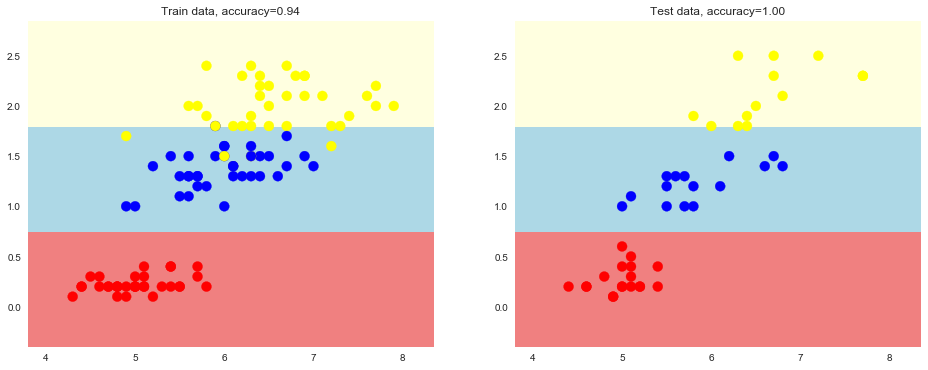

Test_size = 0.4


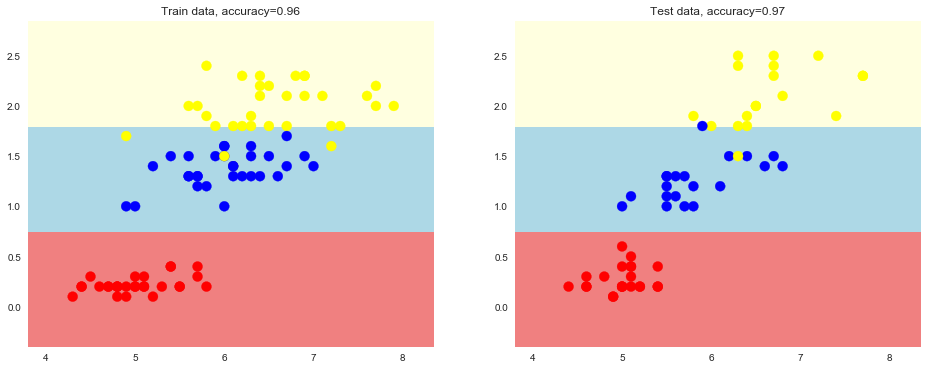

Test_size = 0.5


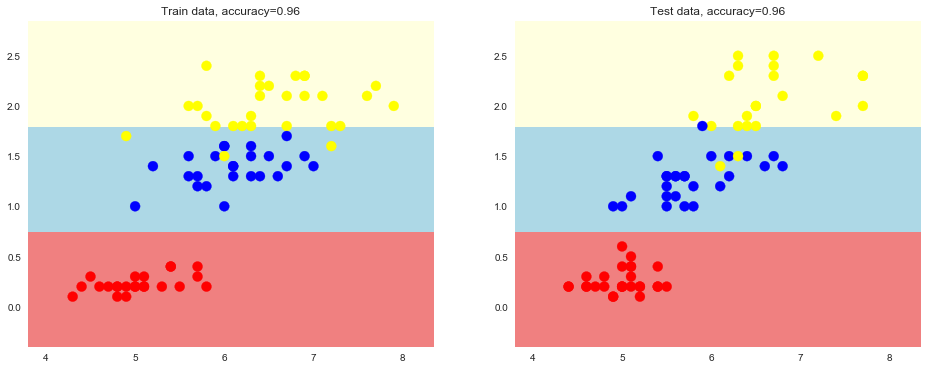

Test_size = 0.6


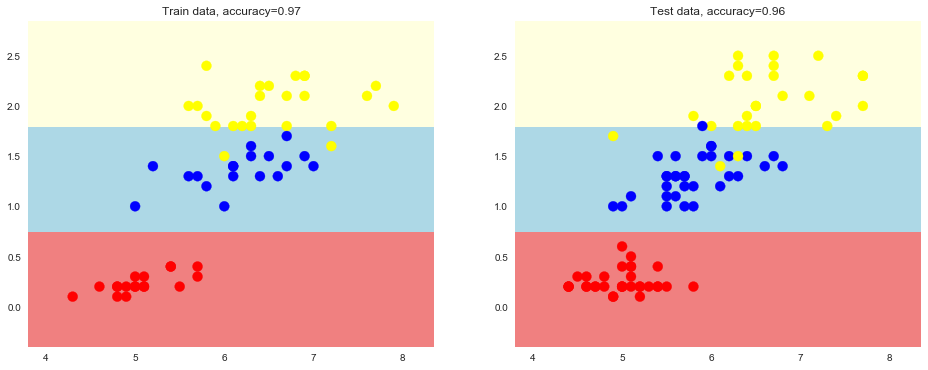

Test_size = 0.7


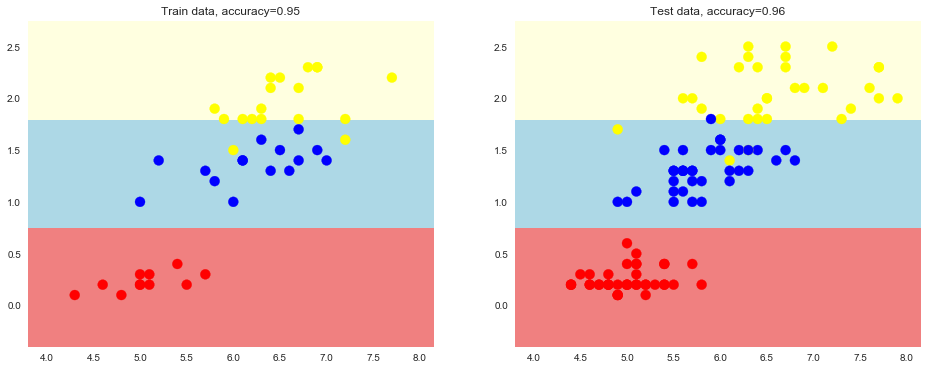

Test_size = 0.8


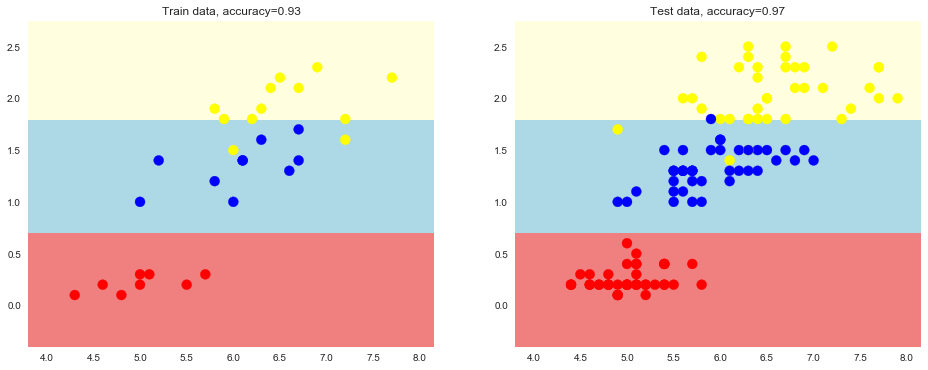

In [11]:
size_for_test = np.arange(0.1, 0.9, 0.1)
errors = []
std_er = []

np.random.seed(1)
for s in size_for_test:
    
    # divide the sample in the ratio of 1-s to s 10 times, train a tree and calculate mean_error and its std
    err = np.zeros(10)
    for i in range(10):
        train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size = s, random_state=i)
        estimator = DecisionTreeClassifier(max_depth=2)
        estimator.fit(train_data, train_labels)
        err[i] += 1-accuracy_score(estimator.predict(test_data), test_labels)
    errors.append(err.mean())
    std_er.append((np.sum((err-err.mean())**2)/3)**0.5)
    
    print ('Test_size =', round(s, 1))
    plot_decision_surface(estimator, train_data, train_labels, test_data, test_labels)

Tne minimum error is on 0.4 test_size.


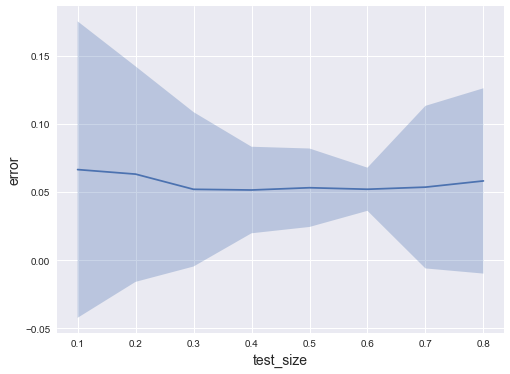

In [12]:
#plot error and its std against test_size
errors = np.array(errors)
plt.figure(figsize=(8,6))
plt.plot(size_for_test, errors)
plt.fill_between(size_for_test, errors-std_er, errors+std_er, alpha=0.3)
plt.xlabel('test_size', fontsize=14)
plt.ylabel('error', fontsize=14)
plt.savefig()
print('Tne minimum error is on', round(size_for_test[np.argmin(errors)], 1), 'test_size.')